In [113]:
import lzma
import pickle

import dask.dataframe as dd
import numpy as np
import pandas as pd
from sklearn import linear_model

In [114]:
from ares import ALL_STRUCTURES
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM

unit_types = ALL_STRUCTURES | UNIT_TRAINED_FROM.keys()
unit_type_values = {u.value for u in unit_types}

In [115]:
def process(df: pd.DataFrame) -> dd.DataFrame:
    return (
        df.pivot_table(index=["replay_name", "game_loop", "player"], columns=["is_own", "unit_type"], values="count")
        .fillna(0)
        .astype(int)
    )

In [116]:
df_train = pd.read_parquet("../resources/datasets/scout/train.parquet")
df_test = pd.read_parquet("../resources/datasets/scout/test.parquet")

In [117]:
from itertools import product


def to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    df = df.reset_index()
    df["is_own"] = df["owner"] == df["player"]
    df = df.pivot_table(
        index=["replay_name", "game_loop", "player"],
        columns=["is_own", "unit_type"],
        values="count",
    )
    df = df.reindex(columns=[(o, t) for o, t in product([False, True], unit_type_values)])
    df = df.fillna(0)
    df = df.astype(int)
    df = df.reset_index()
    df = df.drop(["replay_name", "player"], axis=1, level=0)

    x = df.to_numpy()
    y = np.hstack([x[1::2, :], x[::2, :]]).reshape(x.shape)
    return x, y

In [118]:
df_train

,index,game_loop,unit_type,player,owner,count,replay_name
0,8,1,86,1,1,1,3901860_Sharkling_PhantomBot_EphemeronAIE.SC2R...
1,9,1,86,2,2,1,3901860_Sharkling_PhantomBot_EphemeronAIE.SC2R...
2,10,1,104,1,1,12,3901860_Sharkling_PhantomBot_EphemeronAIE.SC2R...
3,11,1,104,2,2,12,3901860_Sharkling_PhantomBot_EphemeronAIE.SC2R...
4,12,1,106,1,1,1,3901860_Sharkling_PhantomBot_EphemeronAIE.SC2R...
...,...,...,...,...,...,...,...
22210282,1091683,20865,151,2,1,33,3905913_Eris_negativeZero_AutomatonAIE.SC2Repl...
22210283,1091684,20865,694,1,2,2,3905913_Eris_negativeZero_AutomatonAIE.SC2Repl...
22210284,1091685,20865,694,2,2,3,3905913_Eris_negativeZero_AutomatonAIE.SC2Repl...
22210285,1091686,20865,1910,1,2,6,3905913_Eris_negativeZero_AutomatonAIE.SC2Repl...


In [119]:
x_train, y_train = to_numpy(df_train)
x_test, y_test = to_numpy(df_test)

In [120]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
model.coef_

array([[ 1.00000000e+00,  1.78772776e-12,  3.70631256e-11, ...,
         7.07770470e-14,  0.00000000e+00,  0.00000000e+00],
       [-5.62832872e-07, -8.41177269e-04,  1.89931241e-03, ...,
        -3.27001661e-03,  0.00000000e+00,  0.00000000e+00],
       [-1.48034900e-08, -7.00894381e-06, -1.26013651e-04, ...,
         2.76205083e-05,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.72427330e-05,  7.71644115e-03, -2.57909185e-02, ...,
        -7.37532693e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(273, 273))

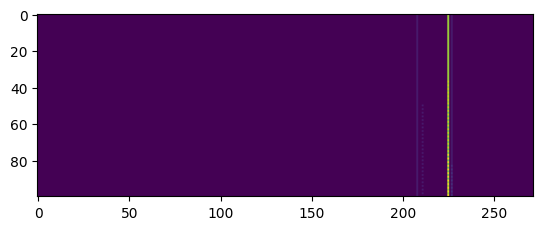

In [121]:
import matplotlib.pyplot as plt

plt.imshow(x_test[:100, 1:])

In [122]:
y_pred = model.predict(x_test)
y_pred

array([[ 3.24982793e-11, -5.14330050e-03,  9.98677869e-04, ...,
         1.34675677e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.24982793e-11, -5.14330050e-03,  9.98677869e-04, ...,
         1.34675677e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.60000000e+01, -5.15230583e-03,  9.98441013e-04, ...,
         1.34399793e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.08480000e+04,  2.39265257e+00, -3.23249400e-04, ...,
         7.06739442e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.08640000e+04, -8.87429490e-03,  3.82566186e-04, ...,
        -4.65408563e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.08640000e+04,  2.38342951e+00, -1.36889012e-03, ...,
         7.30868827e-01,  0.00000000e+00,  0.00000000e+00]],
      shape=(63308, 273))

In [123]:
y_test - y_pred

array([[-3.24982793e-11,  5.14330050e-03, -9.98677869e-04, ...,
        -1.34675677e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.24982793e-11,  5.14330050e-03, -9.98677869e-04, ...,
        -1.34675677e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.24575922e-11,  5.15230583e-03, -9.98441013e-04, ...,
        -1.34399793e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.18278728e-11, -3.92652574e-01,  3.23249400e-04, ...,
        -7.06739442e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.81898940e-11,  8.87429490e-03, -3.82566186e-04, ...,
         4.65408563e-02,  0.00000000e+00,  0.00000000e+00],
       [ 2.18278728e-11, -1.38342951e+00,  1.36889012e-03, ...,
        -7.30868827e-01,  0.00000000e+00,  0.00000000e+00]],
      shape=(63308, 273))

In [124]:
np.mean(np.abs(y_test - y_pred))

np.float64(0.23547588774060646)

In [125]:
with lzma.open("../resources/models/scout.pkl.xz", "wb") as f:
    pickle.dump(model, f)